<a href="https://colab.research.google.com/github/alexchadut/alexchadut/blob/main/maple_leaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries: Setting up the library and prerequisites

In [ ]:
!git clone https://github.com/jurajHasik/peps-torch.git;
!pip install opt_einsum
!cd peps-torch; git fetch origin; git reset --hard origin/feat_maple-leaf
!cd peps-torch; git submodule update --init --recursive

# set up system paths

import sys
if not any(['peps-torch' in x for x in sys.path]):
    sys.path.append('peps-torch')
if not any(['peps-torch/yastn' in x for x in sys.path]):
    sys.path.append('peps-torch/yastn')
print(sys.path)

import numpy as np
import torch

Cloning into 'peps-torch'...
remote: Enumerating objects: 10971, done.
remote: Counting objects: 100% (1260/1260), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 10971 (delta 1225), reused 1193 (delta 1191), pack-reused 9711 (from 1)
Receiving objects: 100% (10971/10971), 8.97 MiB | 4.87 MiB/s, done.
Resolving deltas: 100% (8531/8531), done.
HEAD is now at 651e7fc reimplementation of energy eval done
Submodule 'yastn' (https://github.com/yastn/yastn.git) registered for path 'yastn'
Cloning into '/content/peps-torch/yastn'...
Submodule path 'yastn': checked out 'b75324ebe08cb4b280ba2ae3508d0d0572bc79dd'
['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', 'peps-torch', 'peps-torch/yastn']


In [ ]:
!cd peps-torch; git checkout feat_maple-leaf

Branch 'feat_maple-leaf' set up to track remote branch 'feat_maple-leaf' from 'origin'.
Switched to a new branch 'feat_maple-leaf'


In [ ]:
!cd peps-torch; git reflog

651e7fc (HEAD -> feat_maple-leaf, origin/feat_maple-leaf, master) HEAD@{0}: checkout: moving from master to feat_maple-leaf
651e7fc (HEAD -> feat_maple-leaf, origin/feat_maple-leaf, master) HEAD@{1}: reset: moving to origin/feat_maple-leaf
09910db (origin/master, origin/HEAD) HEAD@{2}: clone: from https://github.com/jurajHasik/peps-torch.git


In [ ]:
import config as cfg
from ipeps.ipeps import *

# 1.1 we create a random D=1 on-site tensor. This corresponds to product state wavefunction
#     of "6 spin-1/2" triangles. Correlated states within "6 spin-1/2" triangles
#     are represented exactly.
bond_dim=1
dphys_1dof=2 # spin-1/2
ndofs= 6     # number of spins coarse-grained into a single site
phys_dim=dphys_1dof**ndofs

# 1.2 Here we pick random arrangement of spins
on_site_tensor= torch.rand( (phys_dim,)+(bond_dim,)*4, )

# 1.3 Alternatively, we can build any particular arrangement
#     For example, a ferromagnetic classical mean field states, i.e. a product state of underlying spin-1/2s
#     is given by tensor product of individual spin states
on_site_tensor= torch.einsum(
    *sum(tuple((torch.as_tensor([1,0.], dtype=cfg.global_args.torch_dtype, device=cfg.global_args.device),[i,]) for i in range(ndofs)),()) \
    ).reshape((phys_dim,)+(1,)*4)

#     For example, a antiferromagnetic classical mean field states, i.e. a product state of underlying spin-1/2s
#     is given by tensor product of individual spin states
# Define spin-up and spin-down states
spin_up = torch.as_tensor([1.0, 0.0], dtype=cfg.global_args.torch_dtype, device=cfg.global_args.device)
spin_down = torch.as_tensor([0.0, 1.0], dtype=cfg.global_args.torch_dtype, device=cfg.global_args.device)

# Create a list of alternating spin states: [spin_up, spin_down, spin_up, ...]
spin_states = [(spin_up if i % 2 == 0 else spin_down, [i]) for i in range(ndofs)]

# Compute the tensor product using einsum
on_site_tensor = torch.einsum(
    *sum(tuple(spin_states), ()),
    ).reshape((phys_dim,) + (1,) * 4)

state= IPEPS(sites={(0,0): on_site_tensor})

/content/peps-torch/ipeps/tensor_io.py:8: Warning: yast not available
  warnings.warn("yast not available", Warning)


# 2. Build a specific product state, use fixed unitary (product of position dependent on-site unitaries), and check expected observables via CTMRG

In [ ]:
from ctm.generic.env import *
from ctm.generic import ctmrg

# 2.1 create CTMRG environment with environment bond dimension \chi (which governs the precision) and initialize it
#     chi=1 corresponds to uncorrelated/product-state boundary MPS
chi=1
ctm_env= ENV(chi, state)
# 2.2 initialize environment tensors. Here, using default approach by constructing them from on-site tensors
init_env(state, ctm_env)

# We will track convergence of CTM using spectra of CTM's corners
# Lets modify generic conv. check to print convergence info
#
def ctmrg_conv_f(*args,**kw_args):
    converged, history= ctmrg_conv_specC(*args,**kw_args)
    print(f"CTM-CONV {len(history['conv_crit'])} {history['conv_crit'][-1]}")
    return converged, history

# converge initial environment
ctm_env, *ctm_log= ctmrg.run(state, ctm_env, conv_check=ctmrg_conv_f)

CTM-CONV 1 inf
CTM-CONV 2 0.0


## 2.2 Evaluate observables on converged environment

In [ ]:
# We define a function, which evaluates selected observable on the state and its converged environment.
# Later, this function will be used throughout the course of optimization reporting i.e. energy and other observables of interest.
# We don't want to differentiate this function.

# 2.2.1 Lets define spin-1/2 irrep, which can be used to get operators
from groups import su2
s2 = su2.SU2(dphys_1dof, dtype=cfg.global_args.torch_dtype, device=cfg.global_args.device)

from ctm.generic import rdm
from itertools import combinations

@torch.no_grad()
def get_observables(state, ctm_env):

    # 2.2.2 let's get 1-site RDM [normalized & symmetrized] and use it to evaluate S^z on each of the 6 spins
    #       The indices of RDM(s) are ordered as |ket><bra|
    r1x1 = rdm.rdm1x1((0,0),state,ctm_env,force_cpu=True).reshape((dphys_1dof,)*(2*ndofs)) # from 2**6 x 2**6 matrix to 12-dim tensor
    _make_r1x1_inds= lambda i: list(range(0,i))+[20+i+ndofs]+list(range(i+1,ndofs))+list(range(0,i))+[20+i]+list(range(i+1,ndofs))

    Szs= [ torch.einsum(r1x1,_make_r1x1_inds(i),s2.SZ(),[20+i,20+i+ndofs]) for i in range(ndofs) ]
    # print results
    for i in range(len(Szs)): print(f"Sz[{i}]={Szs[i].item()}")

    # We can get directly vector S=(Sz,Sx,Sy), where the first index runs over spin operators
    Ss= [ torch.einsum(r1x1,_make_r1x1_inds(i),s2.S(),[51,20+i,20+i+ndofs]) for i in range(ndofs) ]
    for i in range(len(Szs)): print(f"i={i} (Sz,Sx,Sy)= ({Ss[i]}")

    # 2.2.3 let's get 2-site RDM (2x1 or horizontal bond or 2 columns x 1 row)
    #
    #       -->x
    #      |   site(0,0) site(1,0)
    #      V
    #      y
    #
    #       and evaluate spin-spin interactions between all possible bonds of two triangles (containing 6 coarse grained sites).
    #       The indices are sorted as |ket>_site(0,0)|ket>_site(1,0)<bra|_site(0,0)<bra|_site(1,0)
    r2x1 = rdm.rdm2x1((0,0), state, ctm_env, mode='sl', sym_pos_def=False, force_cpu=False,
        unroll=[], checkpoint_unrolled=False, checkpoint_on_device=False, verbosity=0)

    # 2.2.4 This is the place, where we can conveniently insert (any) unitary rotation, i.e. by conjugating RDM
    #       with a unitary U acting on site (1,0)
    # r2x1= torch.einsum(r2x1,[0,1,2,3],U,[11,1],U,[12,3],[0,11,2,12])
    r2x1= r2x1.reshape((dphys_1dof,)*(4*ndofs))

    def _make_r2x1_inds(i,j,inds=[48,49,50,51]):
        assert i!=j, "selected spin-1/2 sites in each 6 spin triangles have to be different"
        res= list(range(2*ndofs))+list(range(2*ndofs))
        res[i]=inds[0]
        res[i+2*ndofs]=inds[1]
        res[j]=inds[2]
        res[j+2*ndofs]=inds[3]
        return res
    SSs= { (i,j): torch.einsum(r2x1,_make_r2x1_inds(i,j),s2.SS(),[48,49,50,51]) for i,j in combinations(range(2*ndofs),2) }
    for i,j in combinations(range(2*ndofs),2): print(f"S_{i}.S_{j}  {SSs[(i,j)]}")

get_observables(state,ctm_env)

Sz[0]=0.5
Sz[1]=-0.5
Sz[2]=0.5
Sz[3]=-0.5
Sz[4]=0.5
Sz[5]=-0.5
i=0 (Sz,Sx,Sy)= (tensor([0.5000, 0.0000, 0.0000], dtype=torch.float64)
i=1 (Sz,Sx,Sy)= (tensor([-0.5000,  0.0000,  0.0000], dtype=torch.float64)
i=2 (Sz,Sx,Sy)= (tensor([0.5000, 0.0000, 0.0000], dtype=torch.float64)
i=3 (Sz,Sx,Sy)= (tensor([-0.5000,  0.0000,  0.0000], dtype=torch.float64)
i=4 (Sz,Sx,Sy)= (tensor([0.5000, 0.0000, 0.0000], dtype=torch.float64)
i=5 (Sz,Sx,Sy)= (tensor([-0.5000,  0.0000,  0.0000], dtype=torch.float64)
S_0.S_1  0.0
S_0.S_2  0.25
S_0.S_3  0.0
S_0.S_4  0.25
S_0.S_5  0.0
S_0.S_6  0.25
S_0.S_7  0.0
S_0.S_8  0.25
S_0.S_9  0.0
S_0.S_10  0.25
S_0.S_11  0.0
S_1.S_2  0.0
S_1.S_3  0.25
S_1.S_4  0.0
S_1.S_5  0.25
S_1.S_6  0.0
S_1.S_7  0.25
S_1.S_8  0.0
S_1.S_9  0.25
S_1.S_10  0.0
S_1.S_11  0.25
S_2.S_3  0.0
S_2.S_4  0.25
S_2.S_5  0.0
S_2.S_6  0.25
S_2.S_7  0.0
S_2.S_8  0.25
S_2.S_9  0.0
S_2.S_10  0.25
S_2.S_11  0.0
S_3.S_4  0.0
S_3.S_5  0.25
S_3.S_6  0.0
S_3.S_7  0.25
S_3.S_8  0.0
S_3.S_9  0.25
S_3.S_10  0

## 2.3 Evaluate energy of (nearest-neighbour) Heisenberg model on maple leaf lattice

### 2.3.1 Define Hamiltonian on maple leaf lattice


In [ ]:
def H_mapleleaf(Jd = 1.0, Jh = 1.0, Jt = 1.0):
    """
    Get H_eff as list of three two-site operators acting on three non-equivalent bonds
    of an effective triangular lattice. Each site of this triangular lattice represents 6 spin-1/2 triangle of underlying maple leaf lattice.

    $H= \sum_k h_0(k,k+(1,0)) + h_1(k,k+(0,1)) + h_2(k,k+(1,-1))$

    Get unitary U

    """
    L = 2*ndofs

    # Define spin operators
    Sz = np.array([[0.5, 0], [0, -0.5]])
    Sp = np.array([[0, 1], [0, 0]])
    Sm = np.array([[0, 0], [1, 0]])
    isigma_y = np.array([[0, 1], [-1, 0]])

    # Helper function for identity matrix
    def I(n):
        return np.eye(n)

    # The couling strength is scaled by 6 to ensure the intra energy is calculated only once
    intra = [
            # Jd couplings
            (1, 2, Jd/6),
            (3, 4, Jd/6),
            (5, 6, Jd/6),
            # Jt couplings
            (2, 4, Jt/6),
            (4, 6, Jt/6),
            (6, 2, Jt/6),
            # Jh couplings
            (2, 3, Jh/6),
            (4, 5, Jh/6),
            (6, 1, Jh/6)
        ]

    # triangular direction (1,0); Unitary: R_y(2pi/3)
    inter10 = [
            (5, 7, Jt),
            (5, 8, Jh)
        ]

    # triangular direction (1,-1); Unitary: R_y(4pi/3)
    inter1_1 = [
            (5, 9, Jt),
            (6, 9, Jh)
        ]

    # triangular direction (0,-1); Unitary: R_y(2pi/3)
    inter0_1 = [
            (1, 9, Jt),
            (1, 10, Jh)
        ]

    # triangular direction (-1,0); Unitary: R_y(4pi/3)
    inter_10 = [
            (1, 11, Jt),
            (2, 11, Jh)
        ]

    # triangular direction (-1,1); Unitary: R_y(2pi/3)
    inter_11 = [
            (3, 11, Jt),
            (3, 12, Jh)
        ]

    # triangular direction (0,1); Unitary: R_y(4pi/3)
    inter01 = [
            (3, 7, Jt),
            (4, 7, Jh)
        ]

    def make_hamil_mat(J_i, s1, s2, L=2*ndofs):
        """
        Generate S.S operator between sites s1 and s2 on Hilbert space of L spin-1/2's
        """
        [s1, s2] = sorted([s1, s2])

        # Compute Hamiltonian using Kronecker products
        hamil = J_i * np.kron(np.kron(np.kron(np.kron(I(2**(s1-1)), Sz), I(2**(s2-s1-1))), Sz), I(2**(L-s2)))
        hamil += 0.5 * J_i * np.kron(np.kron(np.kron(np.kron(I(2**(s1-1)), Sp), I(2**(s2-s1-1))), Sm), I(2**(L-s2)))
        hamil += 0.5 * J_i * np.kron(np.kron(np.kron(np.kron(I(2**(s1-1)), Sm), I(2**(s2-s1-1))), Sp), I(2**(L-s2)))

        return hamil

    def make_unitary_mat(theta):
        """
        Generate Unitary operator applied to site sites s1 on Hilbert space of L/2 spin-1/2's
        """
        uni = I(2) * np.cos(theta/2.0) - isigma_y * np.sin(theta/2.0)

        return uni

    h_eff = [
        np.zeros((2**L, 2**L)),
        np.zeros((2**L, 2**L)),
        np.zeros((2**L, 2**L))
        ]

    # Sum Hamiltonian terms for each pair in local tensor
    for s1, s2, J in intra:
        h_eff[0] += make_hamil_mat(J, s1, s2, L)
        h_eff[0] += make_hamil_mat(J, s1+6, s2+6, L)

        h_eff[1] += make_hamil_mat(J, s1, s2, L)
        h_eff[1] += make_hamil_mat(J, s1+6, s2+6, L)

        h_eff[2] += make_hamil_mat(J, s1, s2, L)
        h_eff[2] += make_hamil_mat(J, s1+6, s2+6, L)

    # triangular direction (1,0)
    for s1, s2, J in inter10:
        h_eff[0] += make_hamil_mat(J, s1, s2, L)

    # triangular direction (0,-1)
    for s1, s2, J in inter0_1:
        h_eff[1] += make_hamil_mat(J, s1, s2, L)

    # triangular direction (-1,1)
    for s1, s2, J in inter_11:
        h_eff[2] += make_hamil_mat(J, s1, s2, L)

    u = make_unitary_mat(2.0*np.pi/3)

    unitary = [
        np.kron(u,np.kron(u,np.kron(u,np.kron(u,np.kron(u,u))))), # triangular direction (1,0)
        np.kron(u,np.kron(u,np.kron(u,np.kron(u,np.kron(u,u))))), # triangular direction (0,-1)
        np.kron(u,np.kron(u,np.kron(u,np.kron(u,np.kron(u,u)))))  # triangular direction (-1,1)
        ]

    h_eff= [torch.as_tensor(t) for t in h_eff]
    unitary= [torch.as_tensor(t) for t in unitary]
    return h_eff, unitary

# 2.3.1.1 Construct bond Hamiltonians [if necessary] and unitaries and save them in file. Otherwise, read them from file
import os
if os.path.isfile("H_eff.pt"):
    data = torch.load("H_eff.pt", weights_only=True)
    H_eff = data["H_eff"]
    U = data["U"]
else:
    H_eff, U= H_mapleleaf()
    torch.save({"H_eff": H_eff, "U": U}, "H_eff.pt")

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-139227583.py:6: SyntaxWarning: invalid escape sequence '\s'
  $H= \sum_k h_0(k,k+(1,0)) + h_1(k,k+(0,1)) + h_2(k,k+(1,-1))$


### 2.3.1.1 Building a initial state from ED

In [ ]:
bond_dim=1

def H_local(Jd = 1.0, Jh = 1.0, Jt = 1.0):
    """
    Get H_local representing 6 spin-1/2 on the maple leaf Unitcell.

    """
    L = ndofs

    # Define spin operators
    Sz = np.array([[0.5, 0], [0, -0.5]])
    Sp = np.array([[0, 1], [0, 0]])
    Sm = np.array([[0, 0], [1, 0]])
    isigma_y = np.array([[0, 1], [-1, 0]])

    # Helper function for identity matrix
    def I(n):
        return np.eye(n)

    intra = [
            # Jd couplings
            (1, 2, Jd-0.01),
            (3, 4, Jd-0.01),
            (5, 6, Jd-0.01),
            # Jt couplings
            (2, 4, Jt),
            (4, 6, Jt),
            (6, 2, Jt),
            # Jh couplings
            (2, 3, Jh),
            (4, 5, Jh),
            (6, 1, Jh)
        ]

    def make_hamil_mat(J_i, s1, s2, L=ndofs):
        """
        Generate S.S operator between sites s1 and s2 on Hilbert space of L spin-1/2's
        """
        [s1, s2] = sorted([s1, s2])

        # Compute Hamiltonian using Kronecker products
        hamil = J_i * np.kron(np.kron(np.kron(np.kron(I(2**(s1-1)), Sz), I(2**(s2-s1-1))), Sz), I(2**(L-s2)))
        hamil += 0.5 * J_i * np.kron(np.kron(np.kron(np.kron(I(2**(s1-1)), Sp), I(2**(s2-s1-1))), Sm), I(2**(L-s2)))
        hamil += 0.5 * J_i * np.kron(np.kron(np.kron(np.kron(I(2**(s1-1)), Sm), I(2**(s2-s1-1))), Sp), I(2**(L-s2)))

        return hamil

    h_eff = [
        np.zeros((2**L, 2**L))
        ]

    # Sum Hamiltonian terms for each pair in local tensor
    for s1, s2, J in intra:
        h_eff += make_hamil_mat(J, s1, s2, L)

    h_eff= torch.as_tensor(h_eff)
    return h_eff

H_loc = H_local()

L, V = torch.linalg.eigh(H_loc)

psi_ground = V[:, 0]

psi_tensor = psi_ground.reshape([2]*ndofs)

on_site_tensor = psi_ground.reshape((2**ndofs, bond_dim, bond_dim, bond_dim, bond_dim))
state = IPEPS(sites={(0,0): on_site_tensor})

In [ ]:
state

### 2.3.2 Define energy evaluation function (to be used later in optimization)

In [ ]:
from ctm.generic import rdm
from itertools import combinations

def get_energy(state, ctm_env):

    # 2.3.2.1 let's get 2-site RDM of (1,0) bond  (2x1 or horizontal bond or 2 columns x 1 row)
    #
    #       -->x
    #      |   site(0,0) site(1,0) => with unitary s0 (U s1 U^\dag)
    #      V
    #      y
    #
    #         and evaluate spin-spin interactions between all possible bonds of two triangles (containing 6 coarse grained sites).
    #         The indices are sorted as |ket>_site(0,0)|ket>_site(1,0)<bra|_site(0,0)<bra|_site(1,0)
    r2x1 = rdm.rdm2x1((0,0), state, ctm_env, mode='sl', sym_pos_def=False, force_cpu=False,
        unroll=[], checkpoint_unrolled=False, checkpoint_on_device=False, verbosity=0)

    # 2.3.2.2 This is the place, where we can conveniently insert (any) unitary rotation, i.e. by conjugating RDM
    #         with a unitary U acting on site (1,0)
    #
    #                        0=|site(0,0)>,1=U|site(1,0)>,2=<site(0,0)|,3=<site(1,0)|U^\dagger
    r2x1= torch.einsum(r2x1,[0,1,2,3],U[0],[11,1],U[0],[12,3],[0,11,2,12])
    ebond_2x1= torch.einsum('ijab,abij',r2x1,H_eff[0].reshape((dphys_1dof**ndofs,)*4))

    # 2.3.2.3 Repeat this evaluation for remaining non-equivalents bonds (using appropriate U if present)
    #         RDM of (0,1) bond (1x2 or vertical or 2 columns x 1 row)
    #
    #       -->x
    #      |   site(0,0) => with unitary  s0
    #      V   site(0,1)                 (U s1 U^\dag)
    #      y
    #
    r1x2 = rdm.rdm1x2((0,0), state, ctm_env, mode='sl', sym_pos_def=False, force_cpu=False,
        unroll=[], checkpoint_unrolled=False, checkpoint_on_device=False, verbosity=0)
    r1x2= torch.einsum(r1x2,[0,1,2,3],U[1],[11,1],U[1],[12,3],[0,11,2,12])
    ebond_1x2= torch.einsum('ijab,abij',r1x2,H_eff[1].reshape((dphys_1dof**ndofs,)*4))

    # RDM of (1,-1) (diagonal of 2 columns x 2 rows)
    #
    #       -->x
    #      |   x         site(1,-1) => with unitary  x  (U s1 U^\dag)
    #      V   site(0,0) x                           s0  x
    #      y
    #
    r2x2_1n1 = rdm.rdm2x2_NNN_1n1((0,0), state, ctm_env, sym_pos_def=False, force_cpu=False,
    unroll=False, checkpoint_unrolled=False, checkpoint_on_device=False, verbosity=0)
    r2x2_1n1= torch.einsum(r2x2_1n1,[0,1,2,3],U[2],[11,1],U[2],[12,3],[0,11,2,12])
    ebond_2x2_1n1= torch.einsum('ijab,abij',r2x2_1n1,H_eff[2].reshape((dphys_1dof**ndofs,)*4))

    return ebond_2x1, ebond_1x2, ebond_2x2_1n1

### 2.3.3 Evaluate the energy on test state

In [ ]:
get_energy(state,ctm_env)

RuntimeError: shape '[20, 1, 1, 20]' is invalid for input of size 3600

## 2.4 Evaluate energy using MPS representation of interaction operators

This avoids working with open large (~ 2**6) physical indices.

### 2.4.1 [DEPRECATED] Re-express operators as mps

Note: This step takes long on slow machines due to repeated SVDs of large matrices

In [ ]:
def get_exact_mps(tensor,ind_dims=None,max_D=np.inf,min_S=-1):
    # max_D = maximal value of bond dimension allowed in the decomposition
    # min_S = smallest (relavite) singular values retained in the decomposition
    # ind_dims = list of index dimensions of "physical" DoFs in resulting MPS
    #
    # Note: The overal scale of the tensor is stored at Ss[-2] in shape (1,) vector of singlar values
    if ind_dims is None:
        ind_dims= tensor.shape
    tmp= tensor.reshape(1,*tensor.shape)
    Us=[]
    Ss=[]
    for i in range(len(ind_dims)):
        # print(i)
        left_aux_D= tmp.shape[0]
        # --tmp--
        #   |
        tmp= tmp.reshape(left_aux_D*ind_dims[i],-1)
        U,S,V= torch.linalg.svd(tmp,full_matrices=False)
        # check number of sing. values larger than min_S
        above_min_S= sum(S>S[0]*min_S)
        retained_D= min(above_min_S,max_D)
        U=U[:,:min(U.shape[1],retained_D)]
        #
        # --
        # == U --
        # print(f"i={i} {U.shape} {S.shape} {V.shape}")
        U= U.reshape(left_aux_D,ind_dims[i],U.shape[1])
        # print(f"i={i} {U.shape}")
        # --U-- S -- V
        #   |
        tmp= (torch.diag(S)[:min(S.shape[0],retained_D),:]@V).reshape(min(S.shape[0],retained_D),-1)
        Us.append(U)
        Ss.append(S[:min(S.shape[0],retained_D)])
    # attach overall sign to the last S
    Ss[-1]= Ss[-1]*V[0,0]

    # debugging information
    for i,u in enumerate(Us):
        print(f"{u.shape} {Ss[i].shape} {sum( (Ss[i]/Ss[i][0]) >min_S)}")
    return Us, Ss

# 2.4.1.1 Construct mps representation of bond Hamiltonians [if necessary] and save them in file. Otherwise, read them from file
import os
if os.path.isfile("H_eff_mps.pt"):
    data = torch.load("H_eff_mps.pt", weights_only=True)
    H_eff_mps = data["H_eff_mps"]
else:
    # We need to permute indices of the effective Hamiltonian apporiately to get compact (small bond dimension) MPS
    H_eff_mps= [dict(zip(('U','S'),get_exact_mps(H_eff[i].reshape((dphys_1dof**ndofs,)*4).permute(0,2,1,3), min_S=1.0e-12))) for i in range(3)]
    # let's add the overall scale of the H_eff to the last mps tensor for each of the three terms
    for i in range(3):
        H_eff_mps[i]['U'][-1]= H_eff_mps[i]['U'][-1]*H_eff_mps[i]['S'][-1]

    torch.save({"H_eff_mps": H_eff_mps,}, "H_eff_mps.pt")

torch.Size([1, 64, 64]) torch.Size([64]) 64
torch.Size([64, 64, 5]) torch.Size([5]) 5
torch.Size([5, 64, 64]) torch.Size([64]) 64
torch.Size([64, 64, 1]) torch.Size([1]) 1
torch.Size([1, 64, 64]) torch.Size([64]) 64
torch.Size([64, 64, 5]) torch.Size([5]) 5
torch.Size([5, 64, 64]) torch.Size([64]) 64
torch.Size([64, 64, 1]) torch.Size([1]) 1
torch.Size([1, 64, 64]) torch.Size([64]) 64
torch.Size([64, 64, 5]) torch.Size([5]) 5
torch.Size([5, 64, 64]) torch.Size([64]) 64
torch.Size([64, 64, 1]) torch.Size([1]) 1


### 2.4.1 Fast MPO operator construction via YASTN

In [ ]:
# import yastn.yastn as yastn
# from yastn.yastn.tn.mps import Hterm, generate_mpo
#
# Or the imports above
#
import yastn
from yastn.tn.mps import Hterm, generate_mpo
import config as cfg

def spiral_u( k,r, sign=-1 ):
    """
    Generate spiral unitary rotation matrix for spin-1/2. Wavevector k is given in units of pi.

        u:= exp( sign (k.r) S^y )
    """
    theta= np.pi*( k[0]*r[0] + k[1]*r[1] )
    isigma_y = torch.as_tensor([[0, 1], [-1, 0]], dtype=torch.float64) # i[[0,-i],[i,0]]
    uni = torch.eye(2,dtype=torch.float64) * np.cos(theta/2.0) + sign * isigma_y * np.sin(theta/2.0)
    U= torch.einsum('ab,cd,ef,gh,ij,kl->acegikbdfhjl',uni,uni,uni,uni,uni,uni).reshape( (2**6,2**6) )
    return U

global_args= cfg.global_args
cfg_dense= yastn.make_config(backend= 'torch', sym= 'dense', \
                                 default_dtype= cfg.global_args.dtype,  default_device= global_args.device)
yastn_s12= yastn.operators.Spin12(**cfg_dense._asdict())

def get_Hterms_SS(s1,s2,J):
    s1,s2=s1-1,s2-1
    return [Hterm(amplitude=J, positions=(s1,s2), operators=(yastn_s12.sz(),yastn_s12.sz())),
            Hterm(amplitude=0.5*J, positions=(s1,s2), operators=(yastn_s12.sp(),yastn_s12.sm())),
            Hterm(amplitude=0.5*J, positions=(s1,s2), operators=(yastn_s12.sm(),yastn_s12.sp()))]

# Cast to format expected by energy evaluation functions. From dummy--O_s1,s1'--...--O_s12,s12'--dummy to
#
# dummy--M_{s1,...,s6}--M_{s1',...,s6'}--M_{s7...s12}--M_{s7'...s12'}--dummy
#
def _cast_mpo(mpo):
    O1= yastn.ncon( tuple(mpo[i] for i in range(0,6)), \
                [[-0,-1,1,-7],[1,-2,2,-8],[2,-3,3,-9],[3,-4,4,-10],[4,-5,5,-11],[5,-6,-13,-12]] )
    O1= O1.to_dense()
    O1= O1.reshape([2**6,]*2 + [O1.shape[-1],])
    U0,S0,V1h= torch.linalg.svd(O1.reshape(2**6, -1), full_matrices=False, driver='gesvd' if O1.is_cuda else None)

    O2= yastn.ncon( tuple(mpo[i] for i in range(6,12)), \
                [[-0,-1,1,-7],[1,-2,2,-8],[2,-3,3,-9],[3,-4,4,-10],[4,-5,5,-11],[5,-6,-13,-12]] )
    O2= O2.to_dense()
    O2= O2.reshape([O2.shape[0],]+[2**6,]*2)
    U2,S2,V2h= torch.linalg.svd(O2.reshape(O2.shape[0] * 2**6, -1), full_matrices=False, driver='gesvd' if O2.is_cuda else None)
    return [ U0.unsqueeze(0), (S0[:,None]*V1h).reshape(U0.shape[-1:] + O1.shape[1:]), \
            U2.reshape( O2.shape[:2] + U2.shape[-1:] ), (S2[:,None]*V2h).unsqueeze(-1) ]


def H_mapleleaf_mpo_yastn(Jd = 1.0, Jh = 1.0, Jt = 1.0, global_args= cfg.global_args, convention='G'):
    """
    Build three MPOs representing Hamiltonian on maple leaf lattice coarse-grained into triangular lattice.
    Each site of triangular lattice represents 6 spin-1/2 triangle of underlying maple leaf lattice.
    Hamiltonian term H_S0S1,S0'S1' is represented in MPO form as::

                            U
        S0                  S1
        |                   |
        H_mps[0]--H_mps[1]--H_mps[2]--H_mps[3]
                  |                   |
                  S0'                 S1'
                                      U^\dagger

    where U is a unitary rotation associated with underlying magnetic texture.

    Returns:
        H_eff_mps: list[list[torch.Tensor]]
            list of three 4-site MPOs
        U:  list[torch.Tensor]
            list of three unitaries associated with action of each MPO
    """
    def get_intra_SS(Jd, Jh, Jt, offset=0):
        intra = [
            # Jd couplings
            (1, 2, Jd/6), (3, 4, Jd/6), (5, 6, Jd/6),
            # Jt couplings
            (2, 4, Jt/6), (4, 6, Jt/6), (6, 2, Jt/6),
            # Jh couplings
            (2, 3, Jh/6), (4, 5, Jh/6), (6, 1, Jh/6)
        ]
        H_terms= []
        for s1,s2,J in intra:
            H_terms+= get_Hterms_SS(s1+offset,s2+offset,J)
        return H_terms

    # convetion for lattice vectors
    #
    # We use 'G' convention for order/labeling of sites within the cluster
    #
    # 1\
    # | 6
    # 2< >5
    # | 4
    # 3/
    #
    # lattice vector conventions
    # 'S'               'G'
    #                   (-a1+a2)= a1_schmoll
    #
    #  --> a2=x          --> a1=x
    # |                 |
    # a1=y              a2=y
    # V                 V
    inter_terms,U=[],[]
    if convention in ['S']:
        inter_terms= {                                     # (a1,a2) S
            (0,1): get_Hterms_SS(5,7,Jt)+get_Hterms_SS(5,8,Jh),   # (0,1)
            (1,0): get_Hterms_SS(3,11,Jt)+get_Hterms_SS(3,12,Jh), # (1,0)
            (1,1): get_Hterms_SS(3,7,Jt)+get_Hterms_SS(4,7,Jh)}   # (1,1)
        U= {d: spiral_u( (2./3., 2./3.),d, sign=1) for d in inter_terms.keys()}
    elif convention in ['G']:
        inter_terms= {                                     # (a1,a2) G
            (1,0): get_Hterms_SS(5,7,Jt)+get_Hterms_SS(5,8,Jh),    # (1,0)  H_eff[0]
            (0,-1): get_Hterms_SS(1,9,Jt)+get_Hterms_SS(1,10,Jh),  # (0,-1) H_eff[1]
            (-1,1): get_Hterms_SS(3,11,Jt)+get_Hterms_SS(3,12,Jh), # (-1,1) [=a1_S]
            (-1,0): get_Hterms_SS(1,5+6,Jt)+get_Hterms_SS(2,5+6,Jh),   # (-1,0)
            (0,1): get_Hterms_SS(3,1+6,Jt)+get_Hterms_SS(4,1+6,Jh),    # (0,1)
            (1,-1): get_Hterms_SS(5,3+6,Jt)+get_Hterms_SS(6,3+6,Jh)}   # (1,-1)
        U= {d: spiral_u( (2./3., 4./3.),d, sign=-1) for d in inter_terms.keys()}
    else:
        raise ValueError(f"Unknown convention {convention}")

    h_mpos= {d: generate_mpo(yastn_s12.I(), opts_svd=None, N=2*6,\
        terms= get_intra_SS(Jd, Jh, Jt, offset=0)+get_intra_SS(Jd, Jh, Jt, offset=6)+inter_terms[d]) for d in inter_terms.keys()}

    return {d: _cast_mpo(h_mpos[d]) for d in h_mpos.keys()}, U

def get_SS(s1,s2,J):
    mpo= generate_mpo(yastn_s12.I(), opts_svd=None, N=2*6, terms= get_Hterms_SS(s1,s2,J))
    return _cast_mpo(mpo)

# def spiral_conjugate(mpo,U):
#     return [mpo[0],mpo[1],torch.einsum('apb,sp->asb',mpo[2],U), torch.einsum('apb,ps->asb',mpo[3],U.H)]

<>:65: SyntaxWarning: invalid escape sequence '\d'
<>:65: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3408881237.py:65: SyntaxWarning: invalid escape sequence '\d'
  U^\dagger


### 2.4.2 Define energy evaluation based on mps format of operators

In [ ]:
import ctm.generic.rdm as rdm

def conjugate_mpo(mpo: list[torch.Tensor], U0: torch.Tensor=None, U1: torch.Tensor=None):
    """
    This is the place, where we can conveniently insert (any) unitary rotation and conjugate (mpo) operator.

    mpo:
        list of 4 tensors representing two-site mpo operator.
    U0, U1:
        unitary tensors acting on first and/or second site as described below.

    The mpo and unitaries are expected to be in the following format:

        A^s0^_(0,0)     A^s1_(1,0)
        U0_xs0          U1_ys1
        x               y
        H0--H1--------- H2--H3      , i.e. H_x'x'xy |x'>|y'><x|<y|
            x'              y'
       (U0^\dagger)_s0'x   (U1^\dagger)_s1'y
        A*^s0'_(0,0)        A*^s1'_(1,0)

    We take the action of unitary on |iPEPS>, i.e. |A> as (U|A>)^s := U^s_p A^p
    and hence on bra's the action is (U|A>)^\dagger = <A|U^\dagger in components (<A|U^\dagger)_s' := A*^p' (U^\dagger)_p's'
    Together

        H_x'x'xy -> U0^+_s0'x' U1^+_s1'y' H_x'x'xy U0_xs0 U1ys1
    """
    return [
        mpo[0] if U0 is None else torch.einsum('axb,xs->asb', mpo[0], U0),
        mpo[1] if U0 is None else torch.einsum('axb,sx->asb', mpo[1], U0.H),
        mpo[2] if U1 is None else torch.einsum('ayb,ys->asb',mpo[2], U1),
        mpo[3] if U1 is None else torch.einsum('ayb,sy->asb',mpo[3], U1.H)
        ]


def get_energy_mpo(state, ctm_env, H_mpos, U):
    """
    H_mpos: list[list[torch.Tensor]]
        list of three 4-site MPOs representing bond Hamiltonians to be evaluated on RDMs
        rdm2x1, rdm1x2, rdm2x2_1n1 in this order
    U:  list[(torch.Tensor, torch.Tensor)]
        list of three pairs unitaries associated with action of each MPO. These are used to conjugate H_eff_mps,
        always acting on first and second site respectively of each bond
    """
    h_eff_10= conjugate_mpo(H_mpos[0], *U[0])
    # Let's evaluate this operator and the norm on 2-site RDM of (1,0) bond (2x1 or horizontal bond or 2 columns x 1 row)
    #
    #       -->x
    #      |   site(0,0) site(1,0) => with unitary s0 s1
    #      V
    #      y
    #
    ebond_2x1,I2x1 = rdm.eval_mpo_rdm2x1((0,0), state, ctm_env, h_eff_10, sym_pos_def=False, force_cpu=False,
        unroll=[], checkpoint_unrolled=False, checkpoint_on_device=False, verbosity=0)


    # 2.4.2.2 Repeat this evaluation for remaining non-equivalents bonds (using appropriate U if present)
    #         RDM of (0,1) bond (1x2 or vertical or 2 columns x 1 row)
    #
    #       -->x
    #      |   site(0,0) => with unitary  s0
    #      V   site(0,1)                  s1
    #      y
    #
    h_eff_01= conjugate_mpo(H_mpos[1], *U[1])
    ebond_1x2,I1x2 = rdm.eval_mpo_rdm1x2((0,0), state, ctm_env, h_eff_01, sym_pos_def=False, force_cpu=False,
        unroll=[], checkpoint_unrolled=False, checkpoint_on_device=False, verbosity=0)

    # RDM of (1,-1) (diagonal of 2 columns x 2 rows)
    #
    #       -->x
    #      |   x         site(1,-1) => with unitary  x  s1
    #      V   site(0,0) x                           s0  x
    #      y
    #
    h_eff_1n1= conjugate_mpo(H_mpos[2], *U[2])
    ebond_2x2_1n1,I2x2_1n1 = rdm.eval_mpo_rdm2x2_NNN_1n1((0,0), state, ctm_env, h_eff_1n1, sym_pos_def=False, force_cpu=False,
        unroll=False, checkpoint_unrolled=False, checkpoint_on_device=False, verbosity=0)

    return (ebond_2x1, ebond_1x2, ebond_2x2_1n1), (I2x1, I1x2, I2x2_1n1)

<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1096804411.py:19: SyntaxWarning: invalid escape sequence '\d'
  (U0^\dagger)_s0'x   (U1^\dagger)_s1'y


### 2.4.3 Evaluate the energy (based mps representations of operators) on test state

In [ ]:
get_energy(state, ctm_env)

RuntimeError: shape '[20, 1, 1, 20]' is invalid for input of size 3600

### 2.4.4 Verify MPS decomposition of NN effective Hamiltonian terms

In [ ]:
#         p            s            q            r
# dummy-- U[0] -- a -- U[1] -- b -- U[2] -- c -- U[3] -- dummy = H_eff_{pqsr} |p>|q><s|<r|
#
print("Verify convention (ours)")
H_eff_mps, U= H_mapleleaf_mpo_yastn(Jd = 1.0, Jh = 1.0, Jt = 1.0, global_args= cfg.global_args, convention='G')
for i,d in enumerate([(1,0), (0,-1), (-1,1)]):
    _h_eff_mps= torch.einsum('pa,asb,bqc,cr->pqsr', H_eff_mps[d][0].squeeze(0), H_eff_mps[d][1], H_eff_mps[d][2], H_eff_mps[d][3].squeeze(-1))
    assert torch.allclose(_h_eff_mps.reshape(2**(2*6),2**(2*6)), H_eff[i],atol=1.0e-12, rtol=1.0)

print("Verify convention (theirs)")
H_eff_mps, U= H_mapleleaf_mpo_yastn(Jd = 1.0, Jh = 1.0, Jt = 1.0, global_args= cfg.global_args, convention='S')
for d,i in [((0,1),0),((1,0),2)]:
    _h_eff_mps= torch.einsum('pa,asb,bqc,cr->pqsr', H_eff_mps[d][0].squeeze(0), H_eff_mps[d][1], H_eff_mps[d][2], H_eff_mps[d][3].squeeze(-1))
    assert torch.allclose(_h_eff_mps.reshape(2**(2*6),2**(2*6)), H_eff[i],atol=1.0e-12, rtol=1.0)

# H_theirs for (1,1)_theirs is equivalent to H_ours for (0,1)_ours, i.e. a permutation of coarsegrained sites on H_eff[1], built for (0,-1)_ours
d=(1,1)
_h_eff_mps= torch.einsum('pa,asb,bqc,cr->pqsr', H_eff_mps[d][0].squeeze(0), H_eff_mps[d][1], H_eff_mps[d][2], H_eff_mps[d][3].squeeze(-1))
H_eff_reversed_sites= H_eff[1].reshape([2**6,]*4).permute(1,0,3,2).reshape([2**12,]*2)
assert torch.allclose(_h_eff_mps.reshape(2**(2*6),2**(2*6)), H_eff_reversed_sites, atol=1.0e-12, rtol=1.0)

Verify convention (ours)
Verify convention (theirs)


## 2.5 Validate expectation values of selected states

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 2.5.1 Read state, converge CTMRG and evaluate observables

In [ ]:
import config as cfg
from ipeps.ipeps import *
from ctm.generic.env import *
from ctm.generic import ctmrg

parser= cfg.get_args_parser()
args, unknown_args = parser.parse_known_args()
cfg.configure(args)
cfg.chi=25
cfg.ctm_args.projector_svd_method= "DEFAULT"
cfg.ctm_args.projector_rsvd_niter= 4

instate="spiralPEPS_mapleLeaf_hamVars_+1.00_+1.00_+1.00_+0.000_chiB_5_chiM_48_pepstorch.json"
# instate="Jd1_D5_state.json"
#instate= "MPL_D5_Jd1Jt1Jh1_chi25_c3_state.json"
state = read_ipeps(instate)

# 3.1.1 We will track convergence of CTM using spectra of CTM's corners
#       Lets modify generic conv. check to print convergence info
#
#       It might be desirable to supress printing here
#
def f_conv_ctm_opt(*args,**kw_args):
    verbosity= kw_args.pop('verbosity',0)
    converged, history= ctmrg_conv_specC(*args,**kw_args)
    # Optionally ?
    if converged:
        print(f"CTM-CONV {len(history['conv_crit'])} {history['conv_crit'][-1]}")
    return converged, history

# create CTMRG environment with environment bond dimension \chi (which governs the precision) and initialize it
ctm_env= ENV(args.chi, state)
init_env(state, ctm_env)

# converge initial environment
ctm_env, *ctm_log= ctmrg.run(state, ctm_env, conv_check=f_conv_ctm_opt)

CTM-CONV 11 7.267863680703173e-09


### 2.5.2 Evaluate energy according to 'theirs' convention
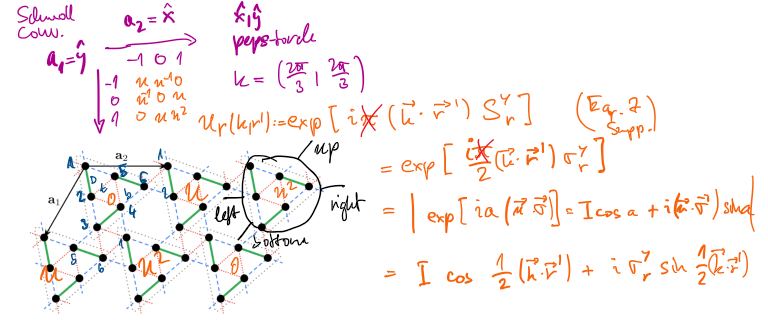

In [ ]:
H_eff_mps, U= H_mapleleaf_mpo_yastn(Jd=1, Jh=1, Jt=1, global_args= cfg.global_args, convention='S')

# This corresponds to u = exp( +i pi (k=(2/3,2/3) . r) S^y ) definition
E_bonds= get_energy_mpo(state, ctm_env, [H_eff_mps[(0,1)], H_eff_mps[(1,0)], H_eff_mps[(1,1)]],
               [(None,U[(0,1)].H),(None,U[(1,0)].H),(None,U[(1,1)].H)])
print(E_bonds)
print(sum(E_bonds[0]).item()/3.)

# Explicit evaluation with correct RDM_11
E_bonds2=0
# The get_energy_mps uses eval_mpo_rdm2x2_NNN_1n1, i.e. RDM for NN sites in (1,-1) direction
#
# .     (1,0)
# (0,1)  .
#
# However, wrt. to 'theirs' convention, we should instead use eval_mpo_rdm2x2_NNN_11
#
# (0,0)  .
#  .    (1,1)
#
d=(1,1)
h_eff_11= conjugate_mpo( H_eff_mps[d], U1=U[d].H )
ebond,nbond = rdm.eval_mpo_rdm2x2_NNN_11((0,0), state, ctm_env, h_eff_11, sym_pos_def=False, force_cpu=False,
    unroll=False, checkpoint_unrolled=False, checkpoint_on_device=False, verbosity=0)
print(ebond,nbond)
E_bonds2+=ebond

d=(0,1)
h_bond= conjugate_mpo( H_eff_mps[d], U1=U[d].H )
ebond,nbond = rdm.eval_mpo_rdm2x1((0,0), state, ctm_env, h_bond, sym_pos_def=False, force_cpu=False,
    unroll=False, checkpoint_unrolled=False, checkpoint_on_device=False, verbosity=0)
print(ebond,nbond)
E_bonds2+=ebond

d=(1,0)
h_bond= conjugate_mpo( H_eff_mps[d], U1=U[d].H )
ebond,nbond = rdm.eval_mpo_rdm1x2((0,0), state, ctm_env, h_bond, sym_pos_def=False, force_cpu=False,
    unroll=False, checkpoint_unrolled=False, checkpoint_on_device=False, verbosity=0)
print(ebond,nbond)
E_bonds2+=ebond

print(f"Energy per spin-1/2: {E_bonds2.item()/6.}")

# compute NN spin-spin correlations
from groups import su2
s2 = su2.SU2(dphys_1dof, dtype=cfg.global_args.torch_dtype, device=cfg.global_args.device)
r1x1 = rdm.rdm1x1((0,0),state,ctm_env,force_cpu=True).reshape((dphys_1dof,)*(2*ndofs)) # from 2**6 x 2**6 matrix to 12-dim tensor
# Jd
r1x1_12= torch.einsum('IJlmnoABlmno->IJAB',r1x1)
r1x1_34= torch.einsum('lmIJnolmABno->IJAB',r1x1)
r1x1_56= torch.einsum('lmnoIJlmnoAB->IJAB',r1x1)
# Jt
r1x1_24= torch.einsum('lImJnolAmBno->IJAB',r1x1)
r1x1_46= torch.einsum('lmnIoJlmnAoB->IJAB',r1x1)
r1x1_62= torch.einsum('lJmnoIlBmnoA->IJAB',r1x1)
# Jh
r1x1_23= torch.einsum('lIJmnolABmno->IJAB',r1x1)
r1x1_45= torch.einsum('lmnIJolmnABo->IJAB',r1x1)
r1x1_61= torch.einsum('JlmnoIBlmnoA->IJAB',r1x1)
for label,R in zip( ["12", "34", "56", "24", "46", "62", "23", "45", "61"], \
 [r1x1_12, r1x1_34, r1x1_56, r1x1_24, r1x1_46, r1x1_62, r1x1_23, r1x1_45, r1x1_61] ):
    SS_corr= torch.einsum('IJAB,ABIJ',R,s2.SS())
    print(f"<S.S>_{label}= {SS_corr}")

# inter-site spin-spin correlations
cfg_dense= yastn.make_config(backend= 'torch', sym= 'dense', \
                        default_dtype= cfg.global_args.dtype,  default_device= cfg.global_args.device)
yastn_s12= yastn.operators.Spin12(**cfg_dense._asdict())
_defaults= dict(sym_pos_def=False, force_cpu=False,
    unroll=[], checkpoint_unrolled=False, checkpoint_on_device=False, verbosity=0)
for label,u,eval_f in [
    [(5,7), U[(0,1)].H, rdm.eval_mpo_rdm2x1],
    [(5,8), U[(0,1)].H, rdm.eval_mpo_rdm2x1],
    [(3,11), U[ (1,0) ].H, rdm.eval_mpo_rdm1x2],
    [(3,12), U[ (1,0) ].H, rdm.eval_mpo_rdm1x2],
    [(3,7), U[(1,1)].H, rdm.eval_mpo_rdm2x2_NNN_11],
    [(4,7), U[(1,1)].H, rdm.eval_mpo_rdm2x2_NNN_11] ]:

    mpo_SS= get_SS(*label,1.)
    mpo_SS= conjugate_mpo(mpo_SS, U1=u)
    ebond,nbond = eval_f((0,0), state, ctm_env, mpo_SS, **_defaults )
    print(f"<S.S>_{label}= {ebond.item()}")

((tensor(-1.0450, dtype=torch.float64), tensor(-0.5228, dtype=torch.float64), tensor(-0.5365, dtype=torch.float64)), (tensor(10868.9734, dtype=torch.float64), tensor(11532.8776, dtype=torch.float64), tensor(5443197.5380, dtype=torch.float64)))
-0.7014610333087994
tensor(-0.5228, dtype=torch.float64) tensor(5443197.5380, dtype=torch.float64)
tensor(-1.0450, dtype=torch.float64) tensor(10868.9734, dtype=torch.float64)
tensor(-0.5228, dtype=torch.float64) tensor(11532.8776, dtype=torch.float64)
Energy per spin-1/2: -0.34844736314985997
<S.S>_12= 0.005353422872171554
<S.S>_34= 0.01794081494648142
<S.S>_56= 0.012908988273227721
<S.S>_24= -0.16247269930996755
<S.S>_46= -0.16279513965136636
<S.S>_62= -0.14885584020509018
<S.S>_23= -0.37106924673062075
<S.S>_45= -0.3755920766550292
<S.S>_61= -0.3839046919842948
<S.S>_(5, 7)= -0.11952457412971726
<S.S>_(5, 8)= -0.40268775054775163
<S.S>_(3, 11)= 1.6677749414620023e-06
<S.S>_(3, 12)= 9.463601321173e-08
<S.S>_(3, 7)= -6.060502437319103e-06
<S.S>_

### 2.5.3 Evaluate energy according to 'ours' convention

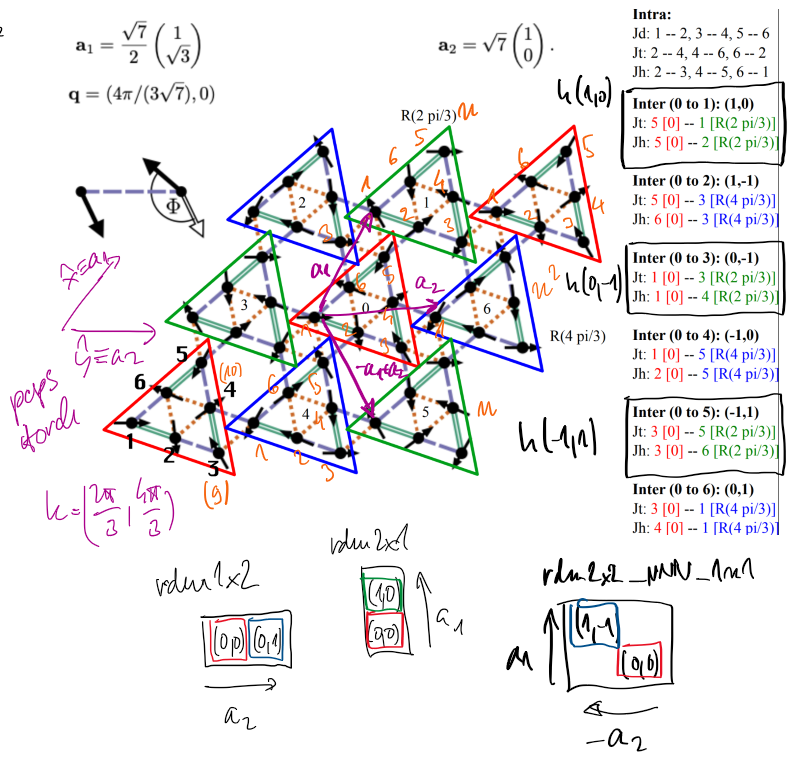

In [ ]:
H_eff_mps, U= H_mapleleaf_mpo_yastn(Jd=1, Jh=1, Jt=1, global_args= cfg.global_args, convention='G')

# This is the energy as evaluated in previous optimizations
#
E_bonds=get_energy_mpo(state, ctm_env, [H_eff_mps[(1,0)], H_eff_mps[(0,-1)], H_eff_mps[(-1,1)]], \
                 [(None,spiral_u( (2./3., 2./3.), (1,0), sign=-1 )),]*3)
print(E_bonds)
print(sum(E_bonds[0]).item())

E_bonds=get_energy_mpo(state, ctm_env, [H_eff_mps[(1,0)], H_eff_mps[(0,1)], H_eff_mps[(1,-1)]], \
                 [(None, U[(1,0)]), (None, U[(0,1)]), (None, U[(1,-1)])])
print(E_bonds)
print(sum(E_bonds[0]).item())

# This is the correct energy, corresponding to k=(2/3,4/3)
# U[1,0]: -2pi/3 =v, U[0,1]: -4pi/3= v^2, U[1,-1]: 2pi/3= v^-1= v^2
#
d=(0,-1)
h_eff_01_reversed= [
    H_eff_mps[d][3].permute(2,1,0),
    H_eff_mps[d][2].permute(2,1,0),
    H_eff_mps[d][1].permute(2,1,0),
    H_eff_mps[d][0].permute(2,1,0)
]
h_eff_01_reversed= conjugate_mpo( h_eff_01_reversed, U1=spiral_u( (2./3, 4./3), (0,1), sign=-1 ) )
ebond,nbond = rdm.eval_mpo_rdm1x2((0,0), state, ctm_env, h_eff_01_reversed, sym_pos_def=False, force_cpu=False,
    unroll=False, checkpoint_unrolled=False, checkpoint_on_device=False, verbosity=0)
print(ebond,nbond)

# compute NN spin-spin correlations
from groups import su2
s2 = su2.SU2(dphys_1dof, dtype=cfg.global_args.torch_dtype, device=cfg.global_args.device)
r1x1 = rdm.rdm1x1((0,0),state,ctm_env,force_cpu=True).reshape((dphys_1dof,)*(2*ndofs)) # from 2**6 x 2**6 matrix to 12-dim tensor
# Jd
r1x1_12= torch.einsum('IJlmnoABlmno->IJAB',r1x1)
r1x1_34= torch.einsum('lmIJnolmABno->IJAB',r1x1)
r1x1_56= torch.einsum('lmnoIJlmnoAB->IJAB',r1x1)
# Jt
r1x1_24= torch.einsum('lImJnolAmBno->IJAB',r1x1)
r1x1_46= torch.einsum('lmnIoJlmnAoB->IJAB',r1x1)
r1x1_62= torch.einsum('lJmnoIlBmnoA->IJAB',r1x1)
# Jh
r1x1_23= torch.einsum('lIJmnolABmno->IJAB',r1x1)
r1x1_45= torch.einsum('lmnIJolmnABo->IJAB',r1x1)
r1x1_61= torch.einsum('JlmnoIBlmnoA->IJAB',r1x1)
for label,R in zip( ["12", "34", "56", "24", "46", "62", "23", "45", "61"], \
 [r1x1_12, r1x1_34, r1x1_56, r1x1_24, r1x1_46, r1x1_62, r1x1_23, r1x1_45, r1x1_61] ):
    SS_corr= torch.einsum('IJAB,ABIJ',R,s2.SS())
    print(f"<S.S>_{label}= {SS_corr}")

# inter-site spin-spin correlations
cfg_dense= yastn.make_config(backend= 'torch', sym= 'dense', \
                        default_dtype= cfg.global_args.dtype,  default_device= cfg.global_args.device)
yastn_s12= yastn.operators.Spin12(**cfg_dense._asdict())
_defaults= dict(sym_pos_def=False, force_cpu=False,
    unroll=[], checkpoint_unrolled=False, checkpoint_on_device=False, verbosity=0)
for label,u,eval_f in [
    [(5,7), U[ (1,0) ], rdm.eval_mpo_rdm2x1],
    [(5,8), U[ (1,0) ], rdm.eval_mpo_rdm2x1],
    [(3,7), U[ (0,1) ], rdm.eval_mpo_rdm1x2],
    [(4,7), U[ (0,1) ], rdm.eval_mpo_rdm1x2],
    [(5,9), U[ (1,-1) ], rdm.eval_mpo_rdm2x2_NNN_1n1],
    [(6,9), U[ (1,-1) ], rdm.eval_mpo_rdm2x2_NNN_1n1] ]:

    mpo_SS= get_SS(*label,1.,)
    mpo_SS= conjugate_mpo(mpo_SS, U1=u)
    ebond,nbond = eval_f((0,0), state, ctm_env, mpo_SS, **_defaults )
    print(f"<S.S>_{label}= {ebond.item()}")

((tensor(-1.0450, dtype=torch.float64), tensor(-0.5228, dtype=torch.float64), tensor(-0.5228, dtype=torch.float64)), (tensor(8571.9132, dtype=torch.float64), tensor(7514.8702, dtype=torch.float64), tensor(3321880.0384, dtype=torch.float64)))
-2.090670950621722
((tensor(-1.0450, dtype=torch.float64), tensor(-1.0670, dtype=torch.float64), tensor(-1.0407, dtype=torch.float64)), (tensor(8571.9132, dtype=torch.float64), tensor(7514.8702, dtype=torch.float64), tensor(3321880.0384, dtype=torch.float64)))
-3.1527613216469685
tensor(-1.0670, dtype=torch.float64) tensor(7514.8702, dtype=torch.float64)
<S.S>_12= 0.005310246170450748
<S.S>_34= 0.017945210749001433
<S.S>_56= 0.012910478878869376
<S.S>_24= -0.1625015818095551
<S.S>_46= -0.16280432585359098
<S.S>_62= -0.14882143099919723
<S.S>_23= -0.37103417802638194
<S.S>_45= -0.3755909062075079
<S.S>_61= -0.38390074428300136
<S.S>_(5, 7)= -0.11949321825693339
<S.S>_(5, 8)= -0.402680489033316
<S.S>_(3, 7)= -0.1692856662090265
<S.S>_(4, 7)= -0.37490

In [ ]:
rho3x2= torch.einsum( 'ab,bi,acx,iyj,cd,dj->xy',
            ctm_env.C[((0,0),(-1,-1))], ctm_env.C[((0,0),(1,-1))],
            ctm_env.T[((0,0),(-1,0))], ctm_env.T[((0,0),(1,0))],
            ctm_env.C[((0,0),(-1,1))], ctm_env.C[((0,0),(1,1))] )
rho_lket_rket= rho3x2.reshape(5,5,5,5)

rho_lket_rket= torch.einsum('lbrb->lr',rho_lket_rket)
U,S,V= torch.linalg.svd(rho_lket_rket)
print(S)

rho_lket_rket= rho3x2.reshape(5,5,5,5)
rho_lket_rket= torch.einsum('blbr->lr',rho_lket_rket)
U,S,V= torch.linalg.svd(rho_lket_rket)
print(S)

rho_lket_rket= rho3x2.reshape(5,5,5,5)
rho_lket_rket= torch.einsum('bblr->lr',rho_lket_rket)
U,S,V= torch.linalg.svd(rho_lket_rket)
print(S)

rho2x3= torch.einsum( 'ba,bi,axc,yij,cd,dj->xy',
            ctm_env.C[((0,0),(-1,-1))], ctm_env.C[((0,0),(-1,1))],
            ctm_env.T[((0,0),(0,-1))], ctm_env.T[((0,0),(0,1))],
            ctm_env.C[((0,0),(1,-1))], ctm_env.C[((0,0),(1,1))] )
rho_lket_rket= rho2x3.reshape(5,5,5,5)
rho_lket_rket= torch.einsum('btbd->td',rho_lket_rket)
U,S,V= torch.linalg.svd(rho_lket_rket)
print(S)

rho_lket_rket= rho2x3.reshape(5,5,5,5)
rho_lket_rket= torch.einsum('bbtd->td',rho_lket_rket)
U,S,V= torch.linalg.svd(rho_lket_rket)
print(S)

rho_lket_rket= rho2x3.reshape(5,5,5,5)
rho_lket_rket= torch.einsum('tdbb->td',rho_lket_rket)
U,S,V= torch.linalg.svd(rho_lket_rket)
print(S)


tensor([1.4072, 1.3988, 1.3923, 1.0412, 0.0795], dtype=torch.float64)
tensor([1.4072, 1.3988, 1.3923, 1.0412, 0.0795], dtype=torch.float64)
tensor([4.3097, 4.0248, 3.7264, 3.3163, 0.7515], dtype=torch.float64)
tensor([1.4357, 1.4352, 1.4351, 1.0045, 0.0942], dtype=torch.float64)
tensor([4.3981, 3.8770, 3.7095, 3.4270, 0.6596], dtype=torch.float64)
tensor([4.1973, 4.0355, 3.6890, 3.2257, 0.9235], dtype=torch.float64)


In [ ]:
import ctm.generic.rdm as rdm
R= rdm.aux_rdm1x1((0,0), state, ctm_env, sym_pos_def=False, verbosity=0)
R.shape

    # 4i) unfuse the D^2 indices and permute to bra,ket
    #
    #   C----T----C      C------T--------C
    #   |    0    |      |      0,1      |
    #   T--1   3--T  =>  T--2,3     6,7--T
    #   |    2    |      |      4,5      |
    #   C----T----C      C------T--------C
    #
R_lL= torch.einsum('uUlLdDrR,sULDR,suxdr->xl',R,state.site((0,0)),state.site((0,0)))

In [ ]:
torch.linalg.svd(R_lL)

torch.return_types.linalg_svd(
U=tensor([[-0.2653, -0.4343, -0.2966,  0.3964, -0.7042],
        [ 0.8602,  0.1333, -0.3908, -0.0820, -0.2879],
        [-0.3708,  0.6626, -0.6435,  0.0831,  0.0488],
        [-0.0497, -0.5923, -0.5857, -0.3046,  0.4592],
        [ 0.2230, -0.0610, -0.0459,  0.8582,  0.4561]], dtype=torch.float64),
S=tensor([36.3815, 22.1500, 14.4168,  5.5899,  0.2904], dtype=torch.float64),
Vh=tensor([[-0.5664,  0.6508,  0.0568,  0.4085, -0.2925],
        [-0.2196,  0.2703,  0.4677, -0.8122, -0.0168],
        [-0.3049, -0.2096, -0.6773, -0.3666, -0.5195],
        [-0.7254, -0.5591,  0.1788,  0.1059,  0.3435],
        [-0.1083,  0.3833, -0.5360, -0.1668,  0.7255]], dtype=torch.float64))

In [ ]:
import ctm.generic.rdm as rdm
R1x1= rdm.rdm1x1((0,0), state, ctm_env, sym_pos_def=False, verbosity=0)
R1x1.shape
U,S,V= torch.linalg.svd(R1x1)
print(S)
# 0+(1+1)+1+0+0+1+(5+5)
# 0+2+1+0+0+1+10

# 1/2 x 1/2 x 1/2 -> 1/2 x (1 x 1/2) -> 1/2 + 1/2 + 3/2
R_t= R1x1.reshape([2,]*(2*6))
R_t= torch.einsum('ixjykziXjYkZ->xyzXYZ', R_t ).reshape([2**3,]*2)
U,S,V= torch.linalg.svd(R_t)
print(S)

tensor([0.2756, 0.0760, 0.0760, 0.0760, 0.0709, 0.0709, 0.0709, 0.0204, 0.0204,
        0.0204, 0.0158, 0.0146, 0.0137, 0.0137, 0.0137, 0.0085, 0.0085, 0.0085,
        0.0085, 0.0085, 0.0080, 0.0080, 0.0080, 0.0080, 0.0080, 0.0054, 0.0054,
        0.0054, 0.0051, 0.0051, 0.0051, 0.0046, 0.0023, 0.0023, 0.0023, 0.0023,
        0.0023, 0.0018, 0.0014, 0.0014, 0.0014, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003], dtype=torch.float64)
tensor([0.2086, 0.2086, 0.1994, 0.1994, 0.0460, 0.0460, 0.0460, 0.0460],
       dtype=torch.float64)


# 3. Optimization

## 3.1 Define loss function

In [ ]:
import time
from ctm.generic.env import *
from ctm.generic import ctmrg

# 3.1.1 We will track convergence of CTM using spectra of CTM's corners
#       Lets modify generic conv. check to print convergence info
#
#       It might be desirable to supress printing here
#
def f_conv_ctm_opt(*args,**kw_args):
    verbosity= kw_args.pop('verbosity',0)
    converged, history= ctmrg_conv_specC(*args,**kw_args)
    # Optionally ?
    if converged and verbosity>0:
        print(f"CTM-CONV {len(history['conv_crit'])} {history['conv_crit'][-1]}")
    return converged, history

# 3.1.2 Loss function, which, given an iPEPS, first performs CTMRG until convergence
#       and then evaluates the energy per site
def loss_fn(state, ctm_env_in, opt_context):
    ctm_args= opt_context["ctm_args"]
    opt_args= opt_context["opt_args"]

    # possibly re-initialize the environment
    if opt_args.opt_ctm_reinit:
        init_env(state, ctm_env_in)

    # 1) compute environment by CTMRG
    t0_ctm= time.perf_counter()
    ctm_env_out, *ctm_log= ctmrg.run(state, ctm_env_in, \
         conv_check=f_conv_ctm_opt, ctm_args=ctm_args)
    ctm_env_out= ctm_env_in
    t1_ctm= time.perf_counter()
    print(f"time CTM {t1_ctm-t0_ctm} [s]")

    t0_e_eval= time.perf_counter()
    # 2) evaluate loss with the converged environment
    #
    #    Here, we can experiment with two options: Evaluating full H_eff operators
    # e_bonds= get_energy(state, ctm_env_out)
    # loss= sum(e_bonds)
    #
    # OR
    #
    # evaluate compact mps representation of H_eff operators
    e_bonds, norm_bonds= get_energy_mps(state, ctm_env_out)
    loss= sum(e_bonds)
    t1_e_eval= time.perf_counter()
    print(f"time loss {t1_e_eval-t0_e_eval} [s]")

    return (loss, ctm_env_out, *ctm_log)

## 3.2 Run optimization

### 3.2.1 Configure optimization

In [ ]:
import torch
import config as cfg
from ipeps.ipeps import *
from ctm.generic.env import *
from ctm.generic import ctmrg

# 3.2.1 Preliminary:
# Here we specify configuration of the simulation (generally this is in the form of command line arguments)
# See for detailed description of options see https://jurajhasik.github.io/peps-torch/config.html
#
import config as cfg
parser= cfg.get_args_parser()
args, unknown_args = parser.parse_known_args()
cfg.configure(args)

cfg.main_args.seed= 1                       # random seed
cfg.main_args.instate_noise= 0.5
cfg.main_args.opt_max_iter=500              # how many optimization steps we do
cfg.main_args.omp_cores= 1
cfg.main_args.test_env_sensitivity= True    # Check error due to finite-chi environment

# governs CTMRG
cfg.ctm_args.projector_svd_reltol= 1.0e-12
cfg.ctm_args.fwd_checkpoint_move= True
cfg.ctm_args.ctm_max_iter=100
cfg.ctm_args.ctm_env_init_type='PROD'

# governs optimization
cfg.opt_args.test_env_sensitivity= 10
cfg.opt_args.tolerance_grad=1.0e-9
cfg.opt_args.tolerance_change=1.0e-10
cfg.opt_args.line_search= 'backtracking'    # using line search



# Print configuration
cfg.print_config()

torch.set_num_threads(args.omp_cores)
torch.manual_seed(cfg.main_args.seed)
torch.set_default_dtype(torch.float64)
torch.set_default_device(cfg.global_args.device)

NumPy: 2.0.2
PyTorch: 2.8.0+cu126
SciPy: 1.16.3
peps-torch git ref: 651e7fc
yast git ref: N/A
MAINARGS
bond_dim= 1
chi= 20
instate= None
instate_noise= 0.5
ipeps_init_type= RANDOM
omp_cores= 1
opt_max_iter= 500
opt_resume= None
opt_resume_override_params= False
out_prefix= output
pattern= None
seed= 1
test_env_sensitivity= True
GLOBALARGS
cuda_mem_profile= False
device= cpu
dtype= float64
offload_to_gpu= None
tensor_io_format= legacy
torch_dtype= torch.float64
verbosity_oe= 0
PEPSARGS
build_dl= True
build_dl_open= False
quasi_gauge_max_iter= 1000000
quasi_gauge_tol= 1e-08
CTMARGS
ad_decomp_reg= 1e-12
conv_check_cpu= False
ctm_absorb_normalization= inf
ctm_conv_tol= 1e-08
ctm_env_init_type= PROD
ctm_force_dl= False
ctm_logging= False
ctm_max_iter= 100
ctm_move_sequence= [(0, -1), (-1, 0), (0, 1), (1, 0)]
ctm_warmup_iter= -1
dtype_rdm= DEFAULT
fpcm_fpt_tol= 1e-08
fpcm_freq= -1
fpcm_init_iter= 1
fpcm_isogauge_tol= 1e-14
fwd_checkpoint_absorb= False
fwd_checkpoint_c2x2= False
fwd_checkpoin

### 3.2.2 Choose initial state

In [ ]:
# We repeat this part here, as it directly relates to initial state setup
cfg.main_args.bond_dim= 3
cfg.main_args.seed= 1                       # random seed
cfg.main_args.instate_noise= 0.5

# option 1: Use prebuilt test state and extend its bond dimension and add noise
state= IPEPS(sites={(0,0): on_site_tensor})

# option 2: Read state from *.json file, i.e. like the ones saved throughout optimization
#
#state= read_ipeps(cfg.main_args.instate)

# option 3: Read state from *_checkpoint.p file, i.e. like the ones saved throughout optimization
# TODO

state= extend_bond_dim(state, cfg.main_args.bond_dim)
state.add_noise(cfg.main_args.instate_noise)

### 3.2.3 Define simplified variant of observables function, reporting properties of the iPEPS state through optimization

In [ ]:
import copy

@torch.no_grad()
def f_obs_opt(state, ctm_env, opt_context):
    # We don't report when in line search mode
    if ("line_search" in opt_context.keys() and not opt_context["line_search"]) \
        or not "line_search" in opt_context.keys():
        epoch= len(opt_context["loss_history"]["loss"])
        loss= opt_context["loss_history"]["loss"][-1]

        # 2.2.2 let's get 1-site RDM [normalized & symmetrized] and use it to evaluate S^z on each of the 6 spins
        #       The indices of RDM(s) are ordered as |ket><bra|
        r1x1 = rdm.rdm1x1((0,0),state,ctm_env,force_cpu=True).reshape((dphys_1dof,)*(2*ndofs)) # from 2**6 x 2**6 matrix to 12-dim tensor
        _make_r1x1_inds= lambda i: list(range(0,i))+[20+i+ndofs]+list(range(i+1,ndofs))+list(range(0,i))+[20+i]+list(range(i+1,ndofs))

        # We can get directly vector S=(Sz,Sx,Sy), where the first index runs over spin operators
        Ss= [ torch.einsum(r1x1,_make_r1x1_inds(i),s2.S(),[51,20+i,20+i+ndofs]) for i in range(ndofs) ]
        print(f"{epoch}, {loss}, "+ ", ".join([f"i={i} (Sz,Sx,Sy)= ({Ss[i]}" for i in range(len(Ss))]) )

        # compute NN spin-spin correlations
        r1x1_12= torch.einsum('IJlmnoABlmno->IJAB',r1x1)
        r1x1_34= torch.einsum('lmIJnolmABno->IJAB',r1x1)
        r1x1_56= torch.einsum('lmnoIJlmnoAB->IJAB',r1x1)
        r1x1_24= torch.einsum('lImJnolAmBno->IJAB',r1x1)
        r1x1_46= torch.einsum('lmnIoJlmnAoB->IJAB',r1x1)
        r1x1_62= torch.einsum('lJmnoIlBmnoA->IJAB',r1x1)
        for label,R in zip( ["12", "34", "56", "24", "46", "62"], [r1x1_12, r1x1_34, r1x1_56, r1x1_24, r1x1_46, r1x1_62] ):
            SS_corr= torch.einsum('IJAB,ABIJ',R,s2.SS())
            print(f"<S.S>_{label}= {SS_corr}")

        # test ENV sensitivity
        if cfg.main_args.test_env_sensitivity:
            loc_ctm_args= copy.deepcopy(opt_context["ctm_args"])
            loc_ctm_args.ctm_max_iter= 1
            ctm_env_out1= ctm_env.extend(ctm_env.chi+10)
            ctm_env_out1, *ctm_log= ctmrg.run(state, ctm_env_out1, \
                conv_check=ctmrg_conv_f, ctm_args=loc_ctm_args)
            e_bonds, norm_bonds= get_energy_mps(state, ctm_env_out1)
            loss1= sum(e_bonds)
            delta_loss= opt_context['loss_history']['loss'][-1]-opt_context['loss_history']['loss'][-2]\
                if len(opt_context['loss_history']['loss'])>1 else float('NaN')
            # if we are not linesearching, this can always happen
            # not "line_search" in opt_context.keys()
            _flag_antivar= (loss1-loss)>0 and \
                (loss1-loss)*opt_context["opt_args"].env_sens_scale>abs(delta_loss)
            opt_context["STATUS"]= "ENV_ANTIVAR" if _flag_antivar else "ENV_VAR"

            print(f"env_sensitivity: {loss1-loss} loss_diff: "\
                +f"{delta_loss}" if cfg.main_args.test_env_sensitivity else ""\
                +" Norm(sites): "+", ".join([f"{t.norm()}" for c,t in state.sites.items()]))

### 3.2.4 Run the optimizer

In [ ]:
from optim.ad_optim_lbfgs_mod import optimize_state

# create CTMRG environment with environment bond dimension \chi (which governs the precision) and initialize it
cfg.main_args.chi=20
chi=cfg.main_args.chi

ctm_env= ENV(chi, state)
init_env(state, ctm_env)

# converge initial environment
ctm_env, *ctm_log= ctmrg.run(state, ctm_env, conv_check=f_conv_ctm_opt)
# evaluate observables on initial state
print("epoch, loss, obs")
f_obs_opt(state, ctm_env, {'loss_history': {'loss': [float('NaN')]}, 'ctm_args': cfg.ctm_args})

# We enter optimization
optimize_state(state, ctm_env, loss_fn, obs_fn=f_obs_opt)

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


epoch, loss, obs
1, nan, i=0 (Sz,Sx,Sy)= (tensor([-0.0081,  0.0030,  0.0000]), i=1 (Sz,Sx,Sy)= (tensor([ 0.0007, -0.0009,  0.0000]), i=2 (Sz,Sx,Sy)= (tensor([-0.0107,  0.0059,  0.0000]), i=3 (Sz,Sx,Sy)= (tensor([0.0004, 0.0050, 0.0000]), i=4 (Sz,Sx,Sy)= (tensor([-0.0075, -0.0001,  0.0000]), i=5 (Sz,Sx,Sy)= (tensor([-0.0044, -0.0170,  0.0000])
<S.S>_12= 0.002444279101683995
<S.S>_34= 0.004482720864044665
<S.S>_56= 0.0028967492913895276
<S.S>_24= 0.000244233301457418
<S.S>_46= 0.007027752277685033
<S.S>_62= -0.010692239946984317
CTM-CONV 1 inf


NameError: name 'get_energy_mps' is not defined

# 4. Invoke self-contained python script to optimize

In [ ]:
# --instate <path-to-my-state>
# --opt_resume <path-to-checkpoint>
!python -u peps-torch/examples/maple_leaf/optim_maple_leaf.py --Jd 1 \
--Jh 1 \
--Jt 1 \
--bond_dim 3 \
--chi 16 \
--out_prefix "trial" \
--seed 1 \
--instate_noise 0.001 \
--opt_max_iter 500 \
--omp_cores 6 \
--test_env_sensitivity \
--GLOBALARGS_device 'cpu' \
--CTMARGS_projector_svd_reltol 1.0e-12 \
--CTMARGS_fwd_checkpoint_move \
--CTMARGS_ctm_max_iter 100 \
--CTMARGS_ctm_env_init_type 'PROD' \
--OPTARGS_env_sens_scale 10 \
--OPTARGS_tolerance_grad 1.0e-9 \
--OPTARGS_tolerance_change 1.0e-10 \
--OPTARGS_line_search 'backtracking' \
--instate '/content/MPL_D5_Jd1Jt1Jh1_chi25_c3_state.json'
#--ipeps_init_type 'MF'
#--CTMARGS_projector_rsvd_niter 4 --CTMARGS_projector_svd_method RSVD_CUSTOM --CTMARGS_ctm_warmup_iter 2

/content/peps-torch/examples/maple_leaf/optim_maple_leaf.py:45: SyntaxWarning: invalid escape sequence '\s'
  $H= \sum_k h_0(k,k+(1,0)) + h_1(k,k+(0,1)) + h_2(k,k+(1,-1))$
/content/peps-torch/examples/maple_leaf/optim_maple_leaf.py:228: SyntaxWarning: invalid escape sequence '\d'
  U^\dagger
/content/peps-torch/examples/maple_leaf/optim_maple_leaf.py:321: SyntaxWarning: invalid escape sequence '\d'
  (U0^\dagger)_s0'x   (U1^\dagger)_s1'y
NumPy: 2.0.2
PyTorch: 2.8.0+cu126
SciPy: 1.16.3
peps-torch git ref: 651e7fc
/bin/sh: 1: cd: can't cd to /content/peps-torch/yast
fatal: not a git repository (or any of the parent directories): .git
yast git ref: N/A
MAINARGS
Jd= 1.0
Jh= 1.0
Jt= 1.0
bond_dim= 3
chi= 16
gauge= False
grad_type= default
instate= /content/MPL_D5_Jd1Jt1Jh1_chi25_c3_state.json
instate_noise= 0.001
ipeps_init_type= RANDOM
loop_rdms= False
omp_cores= 6
opt_max_iter= 500
opt_resume= None
opt_resume_override_params= False
out_prefix= trial
pattern= None
seed= 1
test_env_sensitivi

# Invoke with fixed-point optimization

In [ ]:
!python -u python examples/maple_leaf/optim_maple_leaf.py --Jd 0 --Jh 1 --Jt 1 \
--bond_dim 3 --chi 27 \
--CTMARGS_projector_svd_reltol 1.0e-12 --CTMARGS_ctm_max_iter 500 --CTMARGS_ctm_conv_tol 1.1e-8 \
--CTMARGS_projector_svd_method DEFAULT  --CTMARGS_ctm_env_init_type 'PROD' \
--CTMARGS_projector_rsvd_niter 4 --CTMARGS_ctm_warmup_iter 2 --CTMARGS_warmup_projector_svd_method RSVD \
--CTMARGS_fwd_checkpoint_move \
--OPTARGS_tolerance_grad 1.0e-9 --OPTARGS_tolerance_change 1.0e-10 --OPTARGS_line_search 'backtracking' \
--grad_type fp --OPTARGS_no_opt_ctm_reinit

python3: can't open file '/content/python': [Errno 2] No such file or directory


# Analysis of on-site tensor and symmetry structure

In [ ]:
from opt_einsum import contract
import config as cfg
from ipeps.ipeps import *
import time
import yastn
from yastn.tn import mps, fpeps

# instate="spiralPEPS_mapleLeaf_hamVars_+1.00_+1.00_+1.00_+0.000_chiB_5_chiM_48_pepstorch.json"
instate="Jd1_D5_state.json"
# instate= "MPL_D5_Jd1Jt1Jh1_chi25_c3_state.json"
state = read_ipeps(instate)

# 2. Get on-site double-layer tensor from iPEPS wavefunction
#
#     /          |
#  --a--     = --A--
#   / \  /       |
#    --a*--
#     /
D= state.site((0,0)).shape[1]

A_uu= torch.einsum('suldr,sUldr->uU',state.site((0,0)), state.site((0,0)).conj()).reshape([D,]*2)
U,S,V= torch.linalg.svd(A_uu)
print(f"uu {S/S[0]}")
A_ll= torch.einsum('suldr,suLdr->lL',state.site((0,0)), state.site((0,0)).conj()).reshape([D,]*2)
U,S,V= torch.linalg.svd(A_ll)
print(f"ll {S/S[0]}")
A_rr= torch.einsum('suldr,suldR->rR',state.site((0,0)), state.site((0,0)).conj()).reshape([D,]*2)
U,S,V= torch.linalg.svd(A_rr)
print(f"rr {S/S[0]}")
A_dd= torch.einsum('suldr,sulDr->dD',state.site((0,0)), state.site((0,0)).conj()).reshape([D,]*2)
U,S,V= torch.linalg.svd(A_dd)
print(f"dd {S/S[0]}")

A_uudd= torch.einsum('suldr,sUlDr->uUdD',state.site((0,0)), state.site((0,0)).conj()).reshape([D**2,]*2)
U,S0,Vh= torch.linalg.svd(A_uudd)
print(S0)
A_llrr= torch.einsum('suldr,suLdR->lLrR',state.site((0,0)), state.site((0,0)).conj()).reshape([D**2,]*2)
U,S1,Vh= torch.linalg.svd(A_llrr)
print(S1)

uu tensor([1.0000, 0.8472, 0.8103, 0.7209, 0.6574], dtype=torch.float64)
ll tensor([1.0000, 0.9068, 0.8236, 0.7929, 0.4860], dtype=torch.float64)
rr tensor([1.0000, 0.9094, 0.7698, 0.6579, 0.1023], dtype=torch.float64)
dd tensor([1.0000, 0.9585, 0.9165, 0.8201, 0.0573], dtype=torch.float64)
tensor([4.1445e+01, 4.7221e+00, 4.5452e+00, 4.5147e+00, 2.5054e+00, 1.9988e+00,
        1.7973e+00, 7.6784e-01, 4.5373e-01, 3.3546e-01, 3.2203e-01, 3.0595e-01,
        2.9416e-01, 2.8607e-01, 2.7390e-01, 1.0346e-01, 1.0306e-01, 7.1058e-02,
        6.6640e-02, 6.3630e-02, 5.5288e-02, 1.9431e-02, 1.5644e-02, 1.4788e-02,
        1.0187e-04], dtype=torch.float64)
tensor([4.1821e+01, 8.1312e+00, 8.0916e+00, 8.0004e+00, 2.3687e+00, 2.3167e+00,
        2.2101e+00, 6.9752e-01, 6.9292e-01, 6.4659e-01, 6.0216e-01, 5.4998e-01,
        5.1277e-01, 4.7163e-01, 4.6287e-01, 1.7247e-01, 1.2726e-01, 8.1882e-02,
        7.4342e-02, 6.2510e-02, 4.9959e-02, 4.4477e-02, 4.2809e-02, 8.7370e-03,
        8.5079e-04], dtype

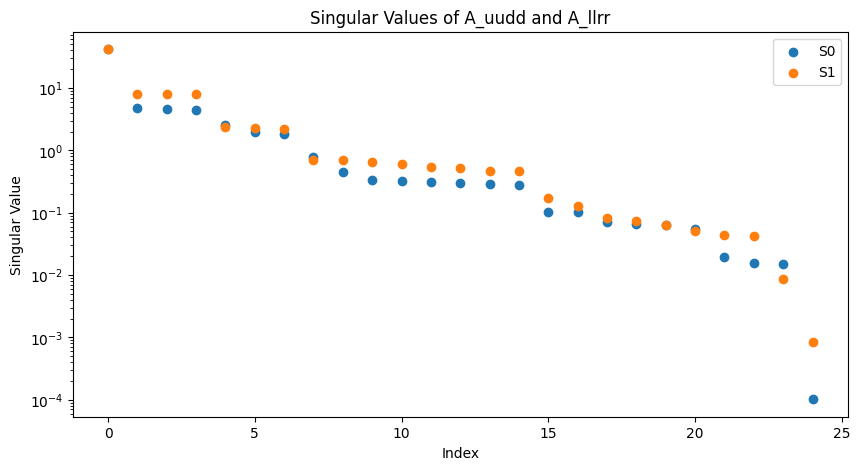

In [ ]:
import matplotlib.pyplot as plt

# uu 0 + 1/2 + ?
# dd

# 0 + 1 + 1 + 8

# (0+1) x (0+1) -> 0 + 1 + 1 + [0 + 1 + 2]
# ()

# Plot S0 and S1
plt.figure(figsize=(10, 5))
plt.scatter(range(len(S0)), S0, label='S0')
plt.scatter(range(len(S1)), S1, label='S1')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of A_uudd and A_llrr')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
import config as cfg
from ipeps.ipeps import *
import time
import yastn
from yastn.tn import mps, fpeps

instate="Jd1_D5_state.json"
state = read_ipeps(instate)

# 1. wrap on-site iPEPS tensor into YASTN tensor
#
cfg_dense= yastn.make_config(backend= 'torch', sym= 'dense', \
                        default_dtype= cfg.global_args.dtype,  default_device= cfg.global_args.device)
a= yastn.Tensor(config=cfg_dense, s=(-1,1,1,-1,1),)
a.set_block(val=state.site((0,0)).permute(1,2,3,4,0), Ds=list(state.site((0,0)).shape[1:])+[2**6,])

g = fpeps.SquareLattice(dims=(1,1), boundary='infinite')
psi = fpeps.Peps(g, tensors={(0,0): a})

env = fpeps.EnvBP(psi, init='eye')
bp_info= env.iterate_(max_sweeps=1000)
print(bp_info)

BP_out(sweeps=1000, max_diff=tensor(1.2157e-15, dtype=torch.float64), converged=None)


In [ ]:
torch.linalg.svd(env[(0,0)].b[()])

torch.return_types.linalg_svd(
U=tensor([[ 1.2099e-01,  3.4388e-02,  5.4722e-01, -7.5760e-01, -3.3283e-01],
        [-5.1736e-01, -2.9875e-01,  8.5375e-04,  2.4052e-01, -7.6501e-01],
        [ 4.9470e-01, -2.9536e-01,  6.1704e-01,  5.3359e-01, -5.0762e-02],
        [ 6.7093e-01,  1.8128e-01, -4.8904e-01, -6.3101e-03, -5.2706e-01],
        [ 1.5107e-01, -8.8852e-01, -2.8400e-01, -2.8886e-01,  1.5368e-01]],
       dtype=torch.float64),
S=tensor([0.5544, 0.4919, 0.4687, 0.3964, 0.2716], dtype=torch.float64),
Vh=tensor([[ 1.2099e-01, -5.1736e-01,  4.9470e-01,  6.7093e-01,  1.5107e-01],
        [ 3.4388e-02, -2.9875e-01, -2.9536e-01,  1.8128e-01, -8.8852e-01],
        [ 5.4722e-01,  8.5375e-04,  6.1704e-01, -4.8904e-01, -2.8400e-01],
        [-7.5760e-01,  2.4052e-01,  5.3359e-01, -6.3101e-03, -2.8886e-01],
        [-3.3283e-01, -7.6501e-01, -5.0762e-02, -5.2706e-01,  1.5368e-01]],
       dtype=torch.float64))

# Analysis on infinite cylinders

In [ ]:
import config as cfg
from ipeps.ipeps import *
import time
import yastn
from yastn.tn import mps, fpeps

# instate="spiralPEPS_mapleLeaf_hamVars_+1.00_+1.00_+1.00_+0.000_chiB_5_chiM_48_pepstorch.json"
# instate="Jd1_D5_state.json"
instate= "MPL_D5_Jd1Jt1Jh1_chi25_c3_state.json"
state = read_ipeps(instate)


print(f"----- geometry cylinder -----")
#
# We will study PEPS transfer matrix by building a PEPS wavefunction
# on infinite (thin) cylinders from iPEPS on-site tensor as
#
#    PBC
#    |                                                                                 /           |
#  --A_(00)--     where is a double-layer tensor of norm network <PEPS|PEPS>, i.e. -- a --     = --A--
#    |                                                                               / \           |
#  --A_(01)--                                                                           \ /
#  ...                                                                               -- a* --
#  --A_(0W-1)--                                                                        /
#    |
#    PBC
#

# 1. wrap on-site iPEPS tensor into YASTN tensor
#
cfg_dense= yastn.make_config(backend= 'torch', sym= 'dense', \
                        default_dtype= cfg.global_args.dtype,  default_device= cfg.global_args.device)
a= yastn.Tensor(config=cfg_dense, s=(-1,1,1,-1,1),)
a.set_block(val=state.site((0,0)).permute(1,2,3,4,0), Ds=list(state.site((0,0)).shape[1:])+[2**6,])
A= yastn.einsum('uldrs,ULDRs->uUlLdDrR',a,a.conj()).fuse_legs(axes=((0,1),(2,3),(4,5),(6,7)))
print(a)
print(A)

TM_spec=[] # store data: width and leading part of spectrum of TM
D_block=2  # number of leading eigenvalues of TM to compute per sector
for W in [3,]:
    # Define PEPS on Wx1 (rows x columns) cylinder
    #
    # See https://yastn.github.io/yastn/theory/fpeps/basics.html for site labeling convention (x,y)
    # on square grids (strips, cylinders, infinite 2d lattice with rectangular unit cells).
    #
    #  --y(column)-->
    # |
    # x(row)
    # |
    # V
    #

    # 2. Build PEPS with cylinder geometry (1 rung of width W)
    #
    g_cyl = fpeps.SquareLattice(dims=(W, 1), boundary='cylinder')
    psi_cyl= fpeps.Peps(g_cyl)
    for x in range(W): # rows (width of the cylinder)
        psi_cyl[x,0]= A

    opts_svd_env = {'D_total': 4 * 2}
    opts_var_env = {"max_sweeps": 8,
                    "normalize": False,
                    "overlap_tol": None,
                    "Schmidt_tol": None}

    # 3. Interpret cylinder PEPS transfer matrix as an MPO
    #
    #         0  2       2*W-2
    #    PBC--A--A--...--A--PBC
    #         1  3       2*W-1
    #
    Top_mps= psi_cyl.transfer_mpo(n=0, dirn='v')

    # 4. Interpret cylinder MPO as a tensor of size (D^2)^(2*W) and then a matrix D^(2W) x D^(2W)
    t0= time.perf_counter()
    Top= Top_mps.to_tensor()
    Top_m= Top.fuse_legs( axes=(list(range(0,2*W,2)),list(range(1,2*W,2))) )
    t1= time.perf_counter()
    print(f"Tranfer matrix as MPO to matrix (rank-2) conversion {t1-t0} [s]")

    non_herm= (Top_m - Top_m.H).norm()
    hermitian = non_herm < 1.0e-14
    if not hermitian:
        print(f"Transfer matrix L {W} not hermitian |T-T.H|_2 {non_herm}")

    if hermitian:
        # TODO implement scipy.linalg.eighs
        t0= time.perf_counter()
        U,S,V= Top.svd(axes=(list(range(0,2*W,2)),list(range(1,2*W,2))), policy="lowrank", D_block=D_block)
        t1= time.perf_counter()

        print(f"leading D={D_block} spec(T) via svds for L= {W} in {t1-t0} [s]")

        max_sec= np.sort([ S[c][0] for c in S.get_blocks_charge() ])
        print(f"gap {max_sec[-1]/max_sec[-2]}")
        for c in S.get_blocks_charge(): print(f"{c} {S[c][:2]}")
    else:
        t0= time.perf_counter()
        U,S,V= Top.eig(axes=(list(range(0,2*W,2)),list(range(1,2*W,2))), policy="fullrank")#, D_block=2)
        t1= time.perf_counter()

        print(f"full spec(T) via eig for L= {W} in {t1-t0} [s]")

        max_sec= np.sort([ S[c][0] for c in S.get_blocks_charge() ])
        print(f"gap {max_sec[-1]/max_sec[-2]}")
        for c in S.get_blocks_charge(): print(f"{c} {S[c][:2]}")

    TM_spec.append([W, S])

/content/peps-torch/ipeps/tensor_io.py:8: Warning: yast not available
  warnings.warn("yast not available", Warning)


----- geometry cylinder -----
dense s= (-1, 1, 1, -1, 1) n= ()
leg charges  : (((),), ((),), ((),), ((),), ((),))
dimensions   : ((5,), (5,), (5,), (5,), (64,))
dense s= (-1, 1, 1, -1) n= ()
leg charges  : (((),), ((),), ((),), ((),))
dimensions   : ((25,), (25,), (25,), (25,))
Tranfer matrix as MPO to matrix (rank-2) conversion 25.77900051100005 [s]
Transfer matrix L 3 not hermitian |T-T.H|_2 1859.2966946185438


## 5.1 PEPS cylinder transfer matrix spectrum via MPO-vec

In [ ]:
from opt_einsum import contract
import config as cfg
from ipeps.ipeps import *
import time
import yastn
from yastn.tn import mps, fpeps

# instate="spiralPEPS_mapleLeaf_hamVars_+1.00_+1.00_+1.00_+0.000_chiB_5_chiM_48_pepstorch.json"
instate="Jd1_D5_state.json"
# instate= "MPL_D5_Jd1Jt1Jh1_chi25_c3_state.json"
state = read_ipeps(instate)

# 1. implement MPO-vector product
#
def mv_ipeps_tm_vec(vec,on_site_dl_A,direction=3):
    # apply ""Hamiltonian", corresponding to transfer matrix (TM) of iPEPS states on cylinder to a vector
    # This TM can be seen as periodic-MPO, with on-site tensor given by double-layer tensor of PEPS
    #
    #                        0
    #              /         ||
    #  H[i] <=> --A*-- =  1==A*A==3
    #            /|/         ||
    #           --A---       2
    #            /
    #
    #  PBC--H[0]-----H[1]----H[3]--...--PBC
    #       0        1 b
    #       v[0]-----v[1]----v[2]--...

    # TODO: this is per-se not a limitation, can be avoided
    assert len(vec.shape)<50
    w= len(vec.shape)
    #
    # MPO acts on the right, i.e. MPO vec -> result
    if direction==3:
        tn= (vec,list(i for i in range(w)),
            *sum( zip( (on_site_dl_A for i in range(w)), ([i+100,i+50,(i+1)%w + 100,i] for i in range(w))), ()),
                list(i+50 for i in range(w)))
    #
    # MPO acts on the "up", i.e. vec MPO -> result
    elif direction==0:
        tn= (vec,list(i for i in range(w)),
            *sum( zip( (on_site_dl_A for i in range(w)), ([i,i+100,i+50,(i+1)%w + 100] for i in range(w))), ()),
                list(i+50 for i in range(w)))
    #
    # MPO acts on the left, i.e. vec MPO -> result
    elif direction==1:
        tn= (vec,list(i for i in range(w)),
            *sum( zip( (on_site_dl_A for i in range(w)), ([i+100,i,(i+1)%w + 100,i+50] for i in range(w))), ()),
                list(i+50 for i in range(w)))

    #[DEBUG] inspect definition of tn above
    # assert len(tn)%2==1
    # for e in range(len(tn[:-1])//2):
    #     print(f"{tn[2*e].shape} {tn[2*e+1]}")

    op_vec= contract(*tn)
    return op_vec

    # Define the LinearOperator for A = B @ C without forming A explicitly.

# 2. Get on-site double-layer tensor from iPEPS wavefunction
#
#     /          |
#  --a--     = --A--
#   / \  /       |
#    --a*--
#     /
D= state.site((0,0)).shape[1]
A= torch.einsum('suldr,sULDR->uUlLdDrR',state.site((0,0)), state.site((0,0)).conj()).reshape([D**2,]*4)

# 3. Choose width w of the transfer matrix and define MPO-vec and vec-MPO products
#
#         0  2       2*W-2
#    PBC--A--A--...--A--PBC
#         1  3       2*W-1
#
w=2
def A_matvec(x):
    # v= Ax
    x= torch.from_numpy(x)
    x= x.reshape([D**2,]*w)
    x= mv_ipeps_tm_vec(x, A, 3)
    # x= mv_ipeps_tm_vec(x, A.permute(1,2,3,0), 3)
    x= x.reshape(-1)
    return x.numpy()

def A_rmatvec(x):
    # v= A^H x
    x= torch.from_numpy(x)
    x= x.reshape([D**2,]*w)
    x= mv_ipeps_tm_vec(x, A.conj(), 1)
    # x= mv_ipeps_tm_vec(x, A.permute(1,2,3,0).conj(), 1)
    x= x.reshape(-1)
    return x.numpy()

from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import eigs
from cmath import polar

# 4. Compute first few eigenvalues
#
Top_linop= LinearOperator(matvec= A_matvec, rmatvec= A_rmatvec, shape=( D**(2*w),)*2, dtype='float64')
Top_evals, Top_evecs= eigs(Top_linop, k=60, M=None, sigma=None, which='LM', v0=None, ncv=None, maxiter=None, tol=0, return_eigenvectors=True, Minv=None, OPinv=None, OPpart=None)

ascending= polar(Top_evals[-1])[0]>polar(Top_evals[0])[0] # ascending in magnitude
if ascending:
    Top_evals= Top_evals[::-1]
norm,phase0= polar(Top_evals[0])
for row in Top_evals:
    r,phase= polar(row)
    print(f"{r} {r/norm}, {phase/np.pi},")

103.46347408310208 1.0, 0.0,
21.346410007557644 0.2063183185827702, 1.0,
22.554092801412917 0.21799087070377535, 0.5058970866863302,
22.554092801412917 0.21799087070377535, -0.5058970866863302,
20.16385893366084 0.19488867073480623, 0.031204411798770072,
20.16385893366084 0.19488867073480623, -0.031204411798770072,
9.702147763928568 0.09377365152204133, 0.0,
6.9815995536288975 0.06747888194843778, 0.5754630060822529,
6.9815995536288975 0.06747888194843778, -0.5754630060822529,
5.7187576230388135 0.055273203163905896, 0.7965339166006207,
5.7187576230388135 0.055273203163905896, -0.7965339166006207,
6.353758959413691 0.06141064772588573, 0.0,
5.686338537390273 0.05495986470377936, 0.0,
3.856052723377529 0.037269700805526204, 1.0,
3.4790331764668254 0.03362571387920396, 0.5118830365888334,
3.4790331764668254 0.03362571387920396, -0.5118830365888334,
3.2663635807905536 0.031570209774388625, 0.681920463606416,
3.2663635807905536 0.031570209774388625, -0.681920463606416,
3.2789840236333805 0

In [ ]:
# W=3
1.0, 0.0,
0.21813549712788424, 0.5060883089810945,
0.21813549712788424, -0.5060883089810945,
0.2062523468184297, 1.0,
0.19467215519598496, -0.03119307317168915,
0.19467215519598496, 0.03119307317168915,

# W=4
1.0, 0.0,
0.20921247818527583, 1.0,
0.20911389237546144, 0.3334891583568254,
0.20911389237546144, -0.3334891583568254,
0.19040095013891248, -0.6383581621029212,
0.19040095013891248, 0.6383581621029212,

In [ ]:
# built projector
DP= 60
A2p= torch.from_numpy(
    contract('lLx,uldr,dLDR,rRy->uxDy',Top_evecs[:,:DP].conj().reshape(A.shape[1],A.shape[1],DP),
                A,A,Top_evecs[:,:DP].reshape(A.shape[3],A.shape[3],DP)))

wP=3
def A2p_matvec(x):
    # v= Ax
    x= torch.from_numpy(x)
    x= x.reshape([DP,]*wP)
    x= mv_ipeps_tm_vec(x, A2p, 3)
    # x= mv_ipeps_tm_vec(x, A.permute(1,2,3,0), 3)
    x= x.reshape(-1)
    return x.numpy()

def A2p_rmatvec(x):
    # v= A^H x
    x= torch.from_numpy(x)
    x= x.reshape([DP,]*wP)
    x= mv_ipeps_tm_vec(x, A2p.conj(), 1)
    # x= mv_ipeps_tm_vec(x, A.permute(1,2,3,0).conj(), 1)
    x= x.reshape(-1)
    return x.numpy()

from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import eigs
from cmath import polar

# 4. Compute first few eigenvalues
#
TopP_linop= LinearOperator(matvec= A2p_matvec, rmatvec= A2p_rmatvec, shape=( DP**(wP),)*2, dtype='complex128')
TopP_evals= eigs(TopP_linop, k=6, M=None, sigma=None, which='LM', v0=None, ncv=None, maxiter=None, tol=0, return_eigenvectors=False, Minv=None, OPinv=None, OPpart=None)

ascending= polar(TopP_evals[-1])[0]>polar(TopP_evals[0])[0] # ascending in magnitude
if ascending:
    TopP_evals= TopP_evals[::-1]
norm,phase0= polar(TopP_evals[0])
for row in TopP_evals:
    r,phase= polar(row)
    print(f"{r} {r/norm}, {phase/np.pi},")

441180991537.15936 1.0, 4.2513647770171044e-05,
94523105698.06847 0.21425017739030822, 0.1599655303341265,
94116521674.53096 0.2133285963808434, -0.16021346511610188,
85032013726.94836 0.19273725604242486, 0.34802881267767116,
84708516231.83711 0.19200400256750946, -0.34815175405370535,
83333751082.60223 0.188887900161454, -0.8529884555535708,
